In [170]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime

# Data prep

In [2]:
data = pd.read_csv("../0.Data/questions.csv")
data = data.iloc[:,3:]
data['question1'] = data['question1'].apply(lambda x: str(x))
data['question2'] = data['question2'].apply(lambda x: str(x))

sents = data['question1'].values.tolist()
sents.extend(data['question2'].values.tolist())

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sents)
data['q1_tokenized'] = tokenizer.texts_to_sequences(data['question1'])
data['q2_tokenized'] = tokenizer.texts_to_sequences(data['question2'])


Max lenth of sequences chosen:  75


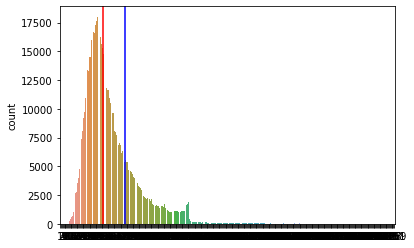

In [3]:
plt.axvline(50, c='red')
plt.axvline(75, c='blue')
sns.countplot(pd.Series([len(x) for x in sents]))
MAX_LEN = 75
print("Max lenth of sequences chosen: ", MAX_LEN)

In [4]:
def pad_sequences(text):

    if len(text) <= MAX_LEN:
        text.extend([0]*(MAX_LEN - len(text)))
    else:
        text = text[:MAX_LEN]

    return text

In [5]:
data['q1_tokenized'] = data['q1_tokenized'].apply(pad_sequences)
data['q2_tokenized'] = data['q2_tokenized'].apply(pad_sequences)

In [45]:
tokenized_data = np.array((np.row_stack(data['q1_tokenized']), np.row_stack(data['q2_tokenized'])))
tokenized_data = tokenized_data.swapaxes(0,1)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(tokenized_data, data['is_duplicate'], stratify=data['is_duplicate'], random_state=42, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, stratify=y_train)

In [48]:
y_train = y_train.values.reshape(-1,1)
y_val = y_val.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [54]:
trainset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size=128).shuffle(buffer_size=5)
validationset = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(batch_size=128)
testset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size=128)

# Model

In [168]:
class sim_model(tf.keras.Model):

    def __init__(self,):
        
        super(sim_model,self).__init__()

        self.emb = tf.keras.layers.Embedding(input_dim = tokenizer.document_count, output_dim = 36, name="Embedding_layer")

        self.lstm1 = tf.keras.layers.LSTM(48, return_sequences = False, name = "LSTM1")
        self.lstm2 = tf.keras.layers.LSTM(48, return_sequences = False, name = "LSTM2")

        self.fc1 = tf.keras.layers.Dense(66, activation='leaky_relu', name = "FullyConnected01")
        self.fc2 = tf.keras.layers.Dense(66, activation='leaky_relu', name = "FullyConnected10")
        self.dotter = tf.keras.layers.Dot(axes=(1,2) ,name = "Cosine_similarity")
        self.out = tf.keras.layers.Dense(1, activation='sigmoid', name = "Sigmoid")

    def call(self, x, training):

        # print("Before embedding: ", x.shape)
        embx1 = self.emb(x[:,0,:])
        embx2 = self.emb(x[:,1,:])
        # print("After embedding: ", embx1.shape)

        seqx1 = self.lstm1(embx1)
        seqx2 = self.lstm2(embx2)
        # print("After LSTM : ", seqx1.shape)

        fcx1 = self.fc1(seqx1)
        fcx2 = self.fc2(seqx2)

        # print("After FC layers: ", fcx1.shape)

        x1_exp = tf.expand_dims(fcx1, axis=2)
        x2_exp = tf.expand_dims(fcx2, axis=2)
        x2_exp = tf.transpose(x2_exp, [0,2,1])
        
        # print("x1 shape after expanding: ", x1_exp.shape)
        # print("x2 shape after expanding and transposing: ", x2_exp.shape)
        
        fcx5 = self.dotter([x1_exp, x2_exp])
        # print("After FC output layer: ", fcx3.shape)

        # print("Before squeezing: ", fcx3)
        fcx5 = tf.squeeze(fcx5, axis=2)
        # print("After squeezing: ", fcx3)

        out = self.out(fcx5)
        return out

In [172]:
similarity_model = sim_model()

similarity_model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics = 'accuracy',
    loss = tf.keras.losses.BinaryCrossentropy()
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


similarity_model.fit(trainset,
epochs=2,
validation_data = validationset,
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'), tensorboard_callback]
)

Epoch 1/2


2022-08-30 17:09:28.326836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-30 17:09:29.326642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-30 17:09:29.335753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-30 17:09:29.879334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-30 17:09:29.945366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2559/2559 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.6306

2022-08-30 17:35:09.805903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-30 17:35:10.270804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-30 17:35:10.289771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2559/2559 [==============================] - 1559s 608ms/step - loss: 0.6609 - accuracy: 0.6306 - val_loss: 0.6591 - val_accuracy: 0.6307
Epoch 2/2
2559/2559 [==============================] - 709s 277ms/step - loss: 0.6587 - accuracy: 0.6308 - val_loss: 0.6590 - val_accuracy: 0.6307
